# Single galaxy test

Here we simulate one galaxy, and run the statmorph test on that galaxy. Potentially can also use this noteobok to run various test series if needed for the paper.

#### Imports

In [24]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import statmorph

# Astropy
from photutils.segmentation import detect_sources
from astropy.stats import sigma_clipped_stats
from astropy.convolution import Gaussian2DKernel, convolve, Tophat2DKernel

# Galsim
from galaxy_generator import (
    get_galaxy_rng_vals, get_augmentation_rng_vals,
    simulate_perfect_galaxy, add_source_to_image, sky_noise
)

In [9]:
plt.rcParams['image.interpolation'] = 'None'

Parameters of the run:

In [2]:
perfect_pxscale = 0.1
seed = 0

## Generate the galaxy

Use some random set of parameters here.

In [30]:
seed = 2

gal_params = get_galaxy_rng_vals(1, seed=seed)[0]
aug_params = dict(sky_mag=23, pxscale=0.3)

# Perfect image
gal_perfect, gal_dict, rpet = simulate_perfect_galaxy(pxscale=perfect_pxscale, **gal_params)
gal_base = add_source_to_image(**gal_dict, pxscale=perfect_pxscale) # Apply PSF
gal_base, _ = sky_noise(gal_base, 30, perfect_pxscale)

# # Observed image
gal_lowres, gal_dict, _ = simulate_perfect_galaxy(**gal_params, **aug_params)
gal_psf = add_source_to_image(**gal_dict, **aug_params)
gal_obs, sky_flux = sky_noise(gal_psf, **aug_params)

Plot the two:

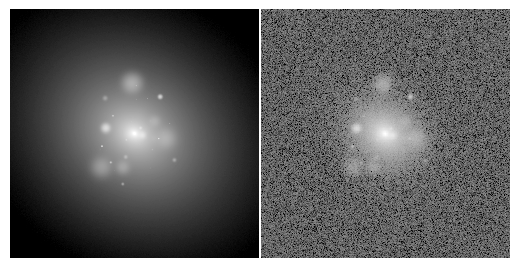

In [31]:
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Statmorph Preparation

### Segmentation map

Generate a segmentation map for both galaxies using `photutils`, the same way we would do it on real data.

In [36]:
def get_segmap(image):
    
    std = sigma_clipped_stats(image)[2]
    kernel = Gaussian2DKernel(5)
    img_smooth = convolve(image, kernel)
    segmap = detect_sources(img_smooth, std, 100)
    return segmap

In [37]:
segmaps = []
for img in [gal_base, gal_obs]:
    segmap = get_segmap(img)
    segmaps.append(segmap)

Plot

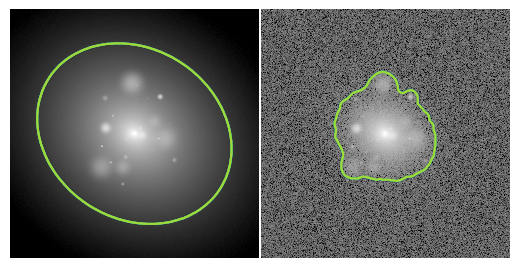

In [33]:
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[0].contour(segmaps[0].data)
axs[1].contour(segmaps[1].data)
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

### Create weightmaps

Instead of using the known noise level, let's estimate the image from the background like we would do normally...

In [38]:
def get_weightmap(image):
    std = sigma_clipped_stats(image)[2]
    noisemap = np.sqrt(image + std**2)
    return noisemap

In [39]:
weightmaps = []
for img in [gal_base, gal_obs]:
    weightmap = get_weightmap(img)
    weightmaps.append(weightmap)

### Create PSFs
This is trivial since we know the PSF, it is always 3 times the pixel scale

In [45]:
psf = Gaussian2DKernel(3).array

## Run statmorph

In [46]:
imgs = [gal_base, gal_obs]
morphs = []

for img, segmap, weight in zip(imgs, segmaps, weightmaps):
    morph = statmorph.source_morphology(img, segmap, weightmap=weight, psf=psf)
    morphs.append(morph)

## Look at output

To do later...